# Leaf Classifier

This notebook demonstrates the possibility to train a classifier with small dataset by utilizing transfer learning.
The classifier is trained to recognize whether the leaf in an image taken by mobile phone is deciduous or coniferous.

The data are stored in two directories with about 500 leaf images in each.

In [18]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Dropout
from keras.applications import MobileNet
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

## Transfer Learning
### Rebuild model

Here, we choose to build on MobileNet model with weights pre-trained on ImageNet dataset.

A 2D pooling layer, a Dense layer and a Dropout layer are added to the model as trainable layers.
A Dense layer is added as the output layer.

In [40]:
def build_and_compile_model():
    base_model = MobileNet(weights='imagenet',include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(rate=0.3)(x)
    preds = Dense(2,activation='softmax')(x)

    model = Model(inputs=base_model.input,outputs=preds)

    # Make all but the new added layers untrainable
    for layer in model.layers[:-3]:
        layer.trainable=False
    

    # Adam optimizer
    # loss function will be categorical cross entropy
    # evaluation metric will be accuracy    
    model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [66]:
model = build_and_compile_model()

/Users/aodanx/opt/anaconda3/envs/tree-classifier/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


### Feature extraction

In [67]:
target_size = (224, 224)
batch_size = 64
epochs = 50

In [68]:
img_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.3)

train_generator = img_datagen.flow_from_directory('../../data/raw/leaf/',
                                                  target_size=target_size,
                                                  color_mode='rgb',
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  subset='training')

Found 797 images belonging to 2 classes.


In [69]:
test_generator = img_datagen.flow_from_directory('../../data/raw/leaf/',
                                                 target_size=target_size,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation')

Found 340 images belonging to 2 classes.


In [70]:
step_size_train=train_generator.n//train_generator.batch_size
history = model.fit_generator(generator=train_generator,
                              validation_data=test_generator,
                              steps_per_epoch=step_size_train,
                              epochs=epochs)

Epoch 1/50
12/12 [==============================] - 31s 3s/step - loss: 1.3331 - accuracy: 0.6784 - val_loss: 0.5411 - val_accuracy: 0.8971
Epoch 2/50
12/12 [==============================] - 31s 3s/step - loss: 0.3045 - accuracy: 0.8811 - val_loss: 0.0720 - val_accuracy: 0.9441
Epoch 3/50
12/12 [==============================] - 31s 3s/step - loss: 0.1604 - accuracy: 0.9441 - val_loss: 0.1127 - val_accuracy: 0.9706
Epoch 4/50
12/12 [==============================] - 31s 3s/step - loss: 0.1334 - accuracy: 0.9482 - val_loss: 0.0588 - val_accuracy: 0.9676
Epoch 5/50
12/12 [==============================] - 30s 3s/step - loss: 0.1302 - accuracy: 0.9583 - val_loss: 0.0658 - val_accuracy: 0.9647
Epoch 6/50
12/12 [==============================] - 29s 2s/step - loss: 0.0728 - accuracy: 0.9782 - val_loss: 0.0524 - val_accuracy: 0.9735
Epoch 7/50
12/12 [==============================] - 30s 3s/step - loss: 0.0744 - accuracy: 0.9768 - val_loss: 0.0588 - val_accuracy: 0.9647
Epoch 8/50
12/12 [==

### Plot loss and accuracy diagrams

In [24]:
def plot_loss(train_loss, val_loss):
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, 'r', label='val_loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
def plot_accuracy(train_acc, val_acc):
    plt.plot(train_acc, label='train_accuracy')
    plt.plot(val_acc, 'r', label='val_accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

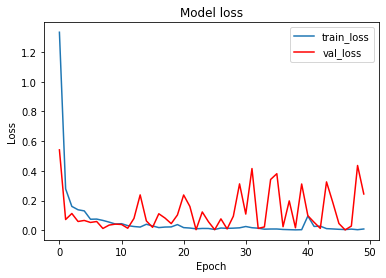

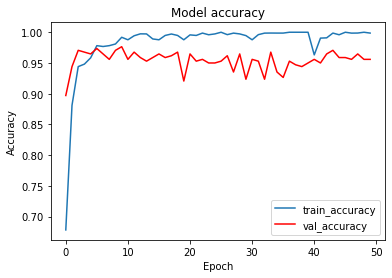

In [71]:
plot_loss(history.history['loss'], history.history['val_loss'])
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

We can see that there is the fluctuation of validation loss and accuracy. This is because that the Dropout layer is added to the model to prevent overfitting.

The validation accuracy is around 95% which is not bad.

### Save weights and history

In [31]:
import pickle

def save_history(history, path):
    with open(path, 'wb') as file_pi:
        pickle.dump(history, file_pi)
        
def load_history(path):
    history = pickle.load(open(path), 'rb')
    return history

In [32]:
model.save_weights('weights.h5')
save_history(history.history, './history')

### Train model with augmented images

Image augmentation can help increase the size of training data.

Image augmentation is only applied to the training data as we want to keep test data as close to the real data as possible.
The data is separated into training and test directories.

In [33]:
train_datagen_aug = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       rotation_range=40,
                                       brightness_range=(0.7,1.3),
                                       zoom_range=0.2)

train_generator = train_datagen_aug.flow_from_directory('../../data/processed/train/',
                                                        target_size=target_size,
                                                        color_mode='rgb',
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=True)

Found 836 images belonging to 2 classes.


In [34]:
test_datagen_aug = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
test_generator = test_datagen_aug.flow_from_directory('../../data/processed/test/',
                                                      target_size=target_size,
                                                      color_mode='rgb',
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      shuffle=True)

Found 300 images belonging to 2 classes.


In [42]:
step_size_train=train_generator.n//train_generator.batch_size
model = build_and_compile_model()
history = model.fit_generator(generator=train_generator,
                              validation_data=test_generator,
                              steps_per_epoch=step_size_train,
                              epochs=epochs)

/Users/aodanx/opt/anaconda3/envs/tree-classifier/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/50
13/13 [==============================] - 37s 3s/step - loss: 1.1163 - accuracy: 0.6875 - val_loss: 0.1204 - val_accuracy: 0.9533
Epoch 2/50
13/13 [==============================] - 32s 2s/step - loss: 0.2279 - accuracy: 0.9003 - val_loss: 0.0575 - val_accuracy: 0.9733
Epoch 3/50
13/13 [==============================] - 33s 3s/step - loss: 0.2173 - accuracy: 0.9106 - val_loss: 0.0688 - val_accuracy: 0.9667
Epoch 4/50
13/13 [==============================] - 35s 3s/step - loss: 0.1767 - accuracy: 0.9339 - val_loss: 0.0892 - val_accuracy: 0.9667
Epoch 5/50
13/13 [==============================] - 32s 2s/step - loss: 0.2025 - accuracy: 0.9199 - val_loss: 0.0903 - val_accuracy: 0.9667
Epoch 6/50
13/13 [==============================] - 32s 2s/step - loss: 0.2213 - accuracy: 0.9443 - val_loss: 0.2151 - val_accuracy: 0.9600
Epoch 7/50
13/13 [==============================] - 34s 3s/step - loss: 0.1875 - accuracy: 0.9267 - val_loss: 0.1937 - val_accuracy: 0.9700
Epoch 8/50
13/13 [==

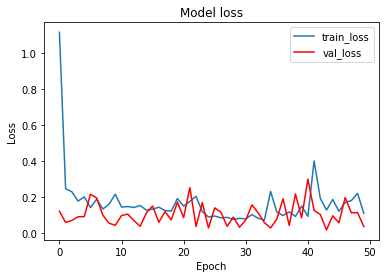

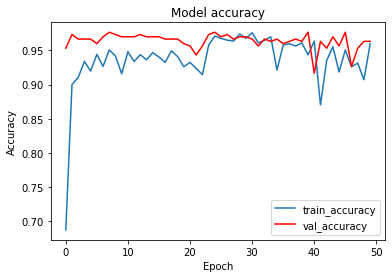

In [44]:
plot_loss(history.history['loss'], history.history['val_loss'])
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

With more training data through image augmentation, the validation loss and accuracy is more stable.

The validation accuracy is around 97%!

In [45]:
model.save_weights('weights_aug.h5')
save_history(history.history, './history_aug')

## Predict Other Images

Here we'll use the classifier to predict unseen images.

In [46]:
train_generator.class_indices

{'coniferous': 0, 'deciduous': 1}

In [60]:
from pathlib import Path

import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input


def extract_features_from_img(img):
    """Convert image into the data that model can use as input."""
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x


def display_img(img):
    plt.imshow(img)
    plt.show()
    

def add_classes(prediction):
    """Add class name to prediction."""
    classes = ['coniferous', 'deciduous']
    return dict(zip(classes, prediction))
    
    
def predict_img(img, model):
    x = extract_features_from_img(img)
    pred = model.predict(x)
    pred_class = add_classes(pred[0])
    print(pred_class)
    
    
def display_and_predict_img(img, model):
    display_img(img)
    predict_img(img, model)
    

def display_and_predict_imgs(dir_path, model, target_size=(224, 224), n_images=10):
    path = Path(dir_path)
    img_paths = list(path.glob('*.jpg'))
    for path in img_paths[:n_images]:
        img = image.load_img(path, target_size=target_size)
        display_and_predict_img(img, model)

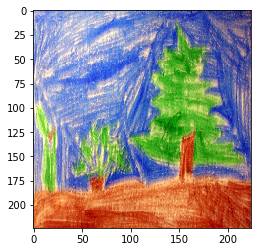

{'coniferous': 0.877267, 'deciduous': 0.122732975}


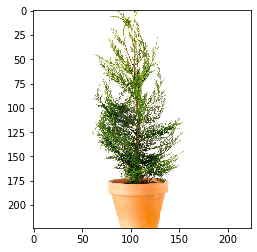

{'coniferous': 0.9939142, 'deciduous': 0.0060858116}


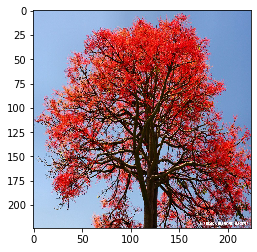

{'coniferous': 0.9517209, 'deciduous': 0.048279036}


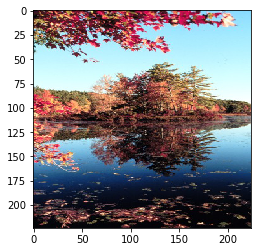

{'coniferous': 0.70984715, 'deciduous': 0.29015285}


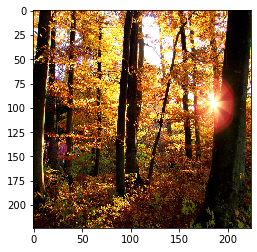

{'coniferous': 0.64343554, 'deciduous': 0.35656443}


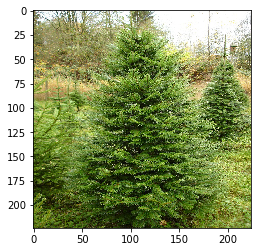

{'coniferous': 0.9924454, 'deciduous': 0.00755466}


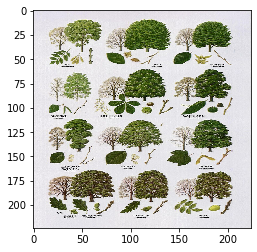

{'coniferous': 0.78804475, 'deciduous': 0.21195523}


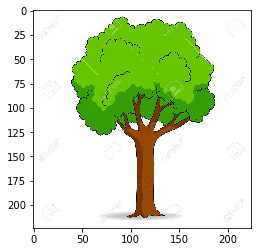

{'coniferous': 0.054971006, 'deciduous': 0.94502896}


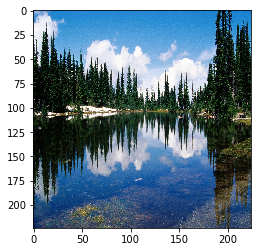

{'coniferous': 0.9271934, 'deciduous': 0.0728066}


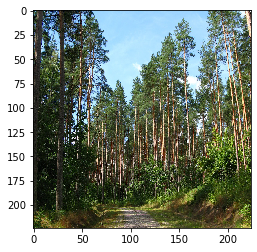

{'coniferous': 0.9067937, 'deciduous': 0.093206316}


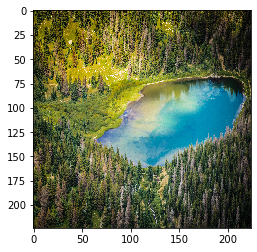

{'coniferous': 0.6697901, 'deciduous': 0.33020994}


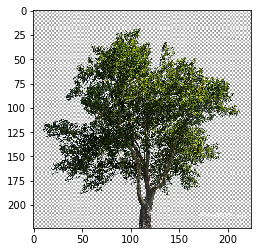

{'coniferous': 0.8714581, 'deciduous': 0.12854192}


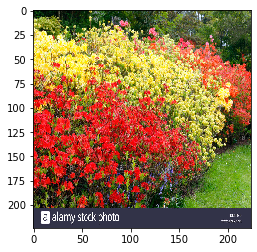

{'coniferous': 0.01750074, 'deciduous': 0.98249924}


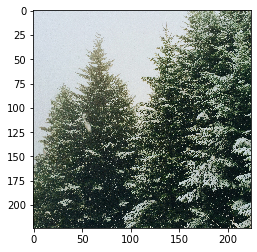

{'coniferous': 0.6443535, 'deciduous': 0.3556464}


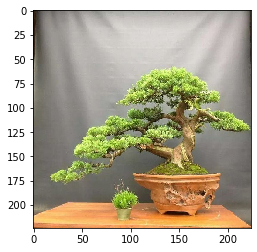

{'coniferous': 0.58377343, 'deciduous': 0.41622657}


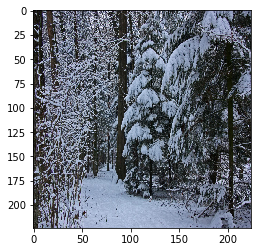

{'coniferous': 0.42559147, 'deciduous': 0.57440853}


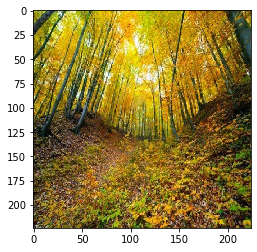

{'coniferous': 0.7744527, 'deciduous': 0.22554731}


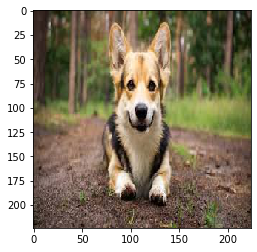

{'coniferous': 0.47172523, 'deciduous': 0.52827483}


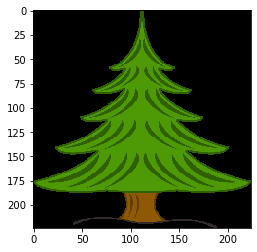

{'coniferous': 0.8347829, 'deciduous': 0.16521715}


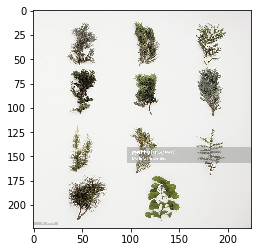

{'coniferous': 0.99186206, 'deciduous': 0.008137939}


In [63]:
misc_img_dir_path = '../../data/raw/misc/'
n_images = 20

display_and_predict_imgs(misc_img_dir_path, model, n_images=n_images)

The classifer is only trained with leaf images. 

However, from the above predictions, we can see that it works pretty well on even field images and hand-drawing images (Please ignore the puppy image!).

## What's Next
* Output image patterns
* Make more layer trainable
* Try a different model architecture
* Try other weights (imagenet is currently used)